<a href="https://colab.research.google.com/github/nikitaoltyan/ML_SRCNN-Super-Resolution-Convolutional-Neural-Network/blob/main/SRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML SRCNN (Super-Resolution-Convolutional-Neural-Network)

Created by Nikita Oltyan and Arseniy Zubenya

In [15]:
import os
import torch
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import time
import torch.optim as optim
import torchvision
import torch.nn as nn
import numpy as np
import math

from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from torchvision import transforms
from sklearn.model_selection import train_test_split

#matplotlib.style.use('ggplot')
#plt.rcParams["axes.grid"] = False

## 1 Downloading data from Drive 

All data was prepared in separate notebook "Data_Preparing.ipynb" and then uploaded on the Google Drive.

In [1]:
# https://drive.google.com/file/d/1QI3MvHTxFzwZfF1xdgJv0EJqB91yAzMG/view?usp=sharing
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':"1QI3MvHTxFzwZfF1xdgJv0EJqB91yAzMG"})   
downloaded.GetContentFile('skyline_data.zip')

In [2]:
! unzip skyline_data.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: skyline_data/train/8142.JPG  
  inflating: skyline_data/train/7271.JPG  
  inflating: skyline_data/train/12059.JPG  
  inflating: skyline_data/train/1600.JPG  
  inflating: skyline_data/train/394.JPG  
  inflating: skyline_data/train/5466.JPG  
  inflating: skyline_data/train/2309.JPG  
  inflating: skyline_data/train/11550.JPG  
  inflating: skyline_data/train/3017.JPG  
  inflating: skyline_data/train/10896.JPG  
  inflating: skyline_data/train/4778.JPG  
  inflating: skyline_data/train/11236.JPG  
  inflating: skyline_data/train/3771.JPG  
  inflating: skyline_data/train/10128.JPG  
  inflating: skyline_data/train/5300.JPG  
  inflating: skyline_data/train/6609.JPG  
  inflating: skyline_data/train/1166.JPG  
  inflating: skyline_data/train/8624.JPG  
  inflating: skyline_data/train/7517.JPG  
  inflating: skyline_data/train/4036.JPG  
  inflating: skyline_data/train/3759.JPG  
  inflating: skyline_data

In [16]:
data_dir = "skyline_data"
train_dir = os.path.join(data_dir, "train/") 
val_dir = os.path.join(data_dir, "val/")
train_fns = os.listdir(train_dir)
val_fns = os.listdir(val_dir)
print(len(train_fns), len(val_fns))

13056 3200


## 2 Analyze data

skyline_data/train/9461.JPG


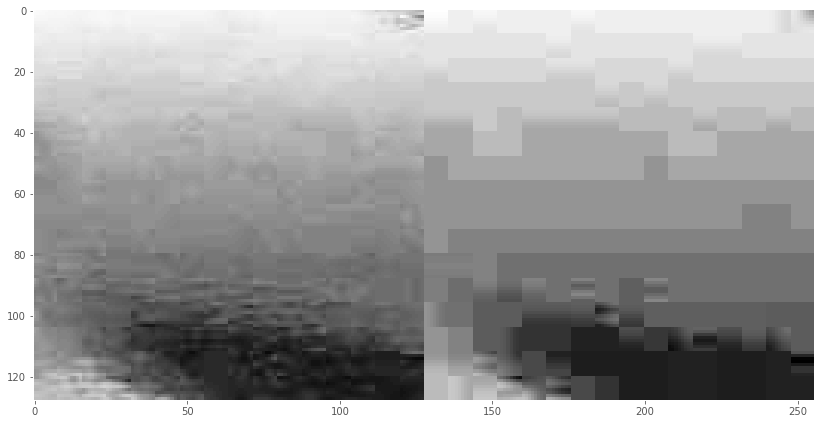

In [17]:
sample_image_fp = os.path.join(train_dir, train_fns[1])
sample_image = Image.open(sample_image_fp).convert("L")
plt.figure(figsize = (14,14))
plt.imshow(sample_image, cmap=matplotlib.cm.Greys_r)
print(sample_image_fp)

In [18]:
def split_image(image):
    image = np.array(image)
    quality, poor = image[:, :128], image[:, 128:]
    return quality, poor

(128, 256)


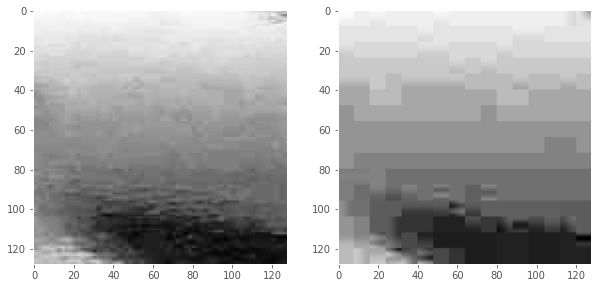

In [67]:
sample_image = np.array(sample_image)
print(sample_image.shape)
quality, poor = split_image(sample_image)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(quality, cmap=matplotlib.cm.Greys_r)
axes[1].imshow(poor, cmap=matplotlib.cm.Greys_r)

## 3 Define Dataset

In [10]:
class SkylineDataset(Dataset):
    
    def __init__(self, image_dir):
        self.image_dir = image_dir
        self.image_fns = os.listdir(image_dir)
        
    def __len__(self):
        return len(self.image_fns)
    
    def __getitem__(self, index):
        image_fn = self.image_fns[index]
        image_fp = os.path.join(self.image_dir, image_fn)
        image = Image.open(image_fp).convert('L')
        quality, poor = self.split_image(image)
        quality = self.transform(quality)
        poor = self.transform(poor)
        return quality, poor
    
    def split_image(self, image):
        image = np.array(image)
        quality, poor = image[:, :128], image[:, 128:]
        return poor, quality

    def transform(self, image):
        transform_ops = transforms.Compose([
            transforms.ToTensor()
        ])
        return transform_ops(image)

In [11]:
dataset = SkylineDataset(train_dir)
print(len(dataset))

13056


In [19]:
quality, poor = dataset[0]
print(quality.shape, poor.shape)

torch.Size([1, 128, 128]) torch.Size([1, 128, 128])


In [ ]:
# train and validation data
train_data = SkylineDataset(train_dir)
val_data = SkylineDataset(val_dir)

# train and validation loaders
train_loader = DataLoader(train_data, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)

## 4 Define Model

### SRCNN

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class SRCNN(nn.Module):
  
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=9, padding=2, padding_mode='replicate')
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=2, padding_mode='replicate')
        self.conv3 = nn.Conv2d(32, 1, kernel_size=5, padding=2, padding_mode='replicate')

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return x

## 5 Train the model

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Computation device: ', device)

In [ ]:
model = SRCNN().to(device)
print(model)

Computation device:  cpu
SRCNN(
  (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2), padding_mode=replicate)
  (conv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2), padding_mode=replicate)
  (conv3): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), padding_mode=replicate)
)


In [ ]:
# Parameters
batch_size = 64
epochs = 10
lr = 1e-2

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

In [6]:
def psnr(label, outputs, max_val=1.):
    """
    Peak Signal to Noise Ratio (the higher the better).
    PSNR = 20 * log10(MAXp) - 10 * log10(MSE).
    label and outputs – Torch tensors.
    """
    label = label.cpu().detach().numpy()
    outputs = outputs.cpu().detach().numpy()
    img_diff = outputs - label
    rmse = math.sqrt(np.mean((img_diff) ** 2))
    if rmse == 0:
        return 100
    else:
        PSNR = 20 * math.log10(max_val / rmse)
        return PSNR

In [ ]:
def train(model, dataloader):
    model.train()
    running_loss = 0.0
    running_psnr = 0.0
    
    for bi, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        image_data = data[0].to(device)
        label = data[1].to(device)
        
        # zero grad the optimizer
        optimizer.zero_grad()
        outputs = model(image_data)
        loss = criterion(outputs, label)

        # backpropagation
        loss.backward()

        # update the parameters
        optimizer.step()

        # add loss of each item (total items in a batch = batch size)
        running_loss += loss.item()

        # calculate batch psnr (once every `batch_size` iterations)
        batch_psnr =  psnr(label, outputs)
        running_psnr += batch_psnr

    final_loss = running_loss/len(dataloader.dataset)
    final_psnr = running_psnr/int(len(train_data)/dataloader.batch_size)
    return final_loss, final_psnr

In [ ]:
def validate(model, dataloader, epoch):
    model.eval()
    running_loss = 0.0
    running_psnr = 0.0

    with torch.no_grad():
        for bi, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            image_data = data[0].to(device)
            label = data[1].to(device)
            
            outputs = model(image_data)
            loss = criterion(outputs, label)
                             
            # add loss of each item (total items in a batch = batch size) 
            running_loss += loss.item()

            # calculate batch psnr (once every `batch_size` iterations)
            batch_psnr = psnr(label, outputs)
            running_psnr += batch_psnr

    final_loss = running_loss/len(dataloader.dataset)
    final_psnr = running_psnr/int(len(val_data)/dataloader.batch_size)
    return final_loss, final_psnr

In [ ]:
train_loss, val_loss = [], []
train_psnr, val_psnr = [], []
start = time.time()
for epoch in range(epochs):
    print(f"Epoch {epoch + 1} of {epochs}")
    train_epoch_loss, train_epoch_psnr = train(model, train_loader)
    val_epoch_loss, val_epoch_psnr = validate(model, val_loader, epoch)
    save_path = 'checkpoint_' + str(epoch) + '.pth'
    torch.save(model.state_dict(), save_path)
    print(f"Train PSNR: {train_epoch_psnr:.3f}")
    print(f"Val PSNR: {val_epoch_psnr:.3f}")
    train_loss.append(train_epoch_loss)
    train_psnr.append(train_epoch_psnr)
    val_loss.append(val_epoch_loss)
    val_psnr.append(val_epoch_psnr)
end = time.time()
print(f"Finished training in: {((end-start)/60):.3f} minutes")


  0%|          | 0/816 [00:00<?, ?it/s]

Epoch 1 of 10



100%|██████████| 816/816 [16:20<00:00,  1.20s/it]

100%|██████████| 200/200 [01:17<00:00,  2.57it/s]

  0%|          | 0/816 [00:00<?, ?it/s]

Train PSNR: 24.424
Val PSNR: 26.873
Epoch 2 of 10



100%|██████████| 816/816 [16:19<00:00,  1.20s/it]

100%|██████████| 200/200 [01:18<00:00,  2.54it/s]

  0%|          | 0/816 [00:00<?, ?it/s]

Train PSNR: 28.325
Val PSNR: 29.619
Epoch 3 of 10



100%|██████████| 816/816 [16:34<00:00,  1.22s/it]

100%|██████████| 200/200 [01:22<00:00,  2.43it/s]

  0%|          | 0/816 [00:00<?, ?it/s]

Train PSNR: 29.337
Val PSNR: 30.065
Epoch 4 of 10



100%|██████████| 816/816 [16:56<00:00,  1.25s/it]

100%|██████████| 200/200 [01:19<00:00,  2.53it/s]

  0%|          | 0/816 [00:00<?, ?it/s]

Train PSNR: 29.597
Val PSNR: 30.090
Epoch 5 of 10



100%|██████████| 816/816 [16:25<00:00,  1.21s/it]

100%|██████████| 200/200 [01:19<00:00,  2.50it/s]

  0%|          | 0/816 [00:00<?, ?it/s]

Train PSNR: 29.714
Val PSNR: 30.208
Epoch 6 of 10



100%|██████████| 816/816 [16:30<00:00,  1.21s/it]

100%|██████████| 200/200 [01:20<00:00,  2.50it/s]

  0%|          | 0/816 [00:00<?, ?it/s]

Train PSNR: 29.824
Val PSNR: 25.022
Epoch 7 of 10



100%|██████████| 816/816 [16:27<00:00,  1.21s/it]

100%|██████████| 200/200 [01:20<00:00,  2.48it/s]

  0%|          | 0/816 [00:00<?, ?it/s]

Train PSNR: 27.359
Val PSNR: 29.173
Epoch 8 of 10



100%|██████████| 816/816 [16:31<00:00,  1.22s/it]

100%|██████████| 200/200 [01:20<00:00,  2.47it/s]

  0%|          | 0/816 [00:00<?, ?it/s]

Train PSNR: 29.392
Val PSNR: 29.747
Epoch 9 of 10



100%|██████████| 816/816 [16:38<00:00,  1.22s/it]

100%|██████████| 200/200 [01:21<00:00,  2.45it/s]

  0%|          | 0/816 [00:00<?, ?it/s]

Train PSNR: 29.193
Val PSNR: 29.914
Epoch 10 of 10



100%|██████████| 816/816 [16:39<00:00,  1.23s/it]

100%|██████████| 200/200 [01:22<00:00,  2.42it/s]

Train PSNR: 30.068
Val PSNR: 30.055
Finished training in: 178.822 minutes


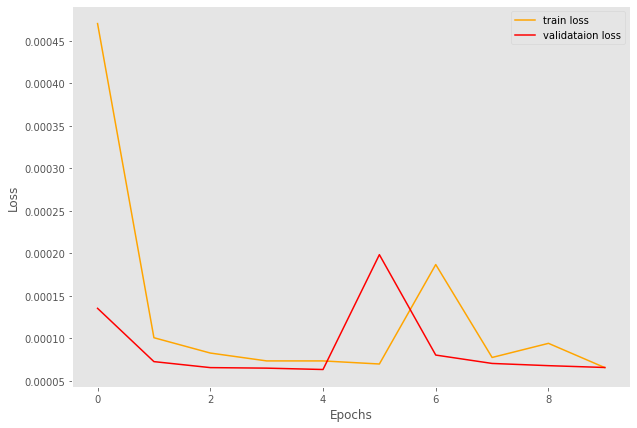

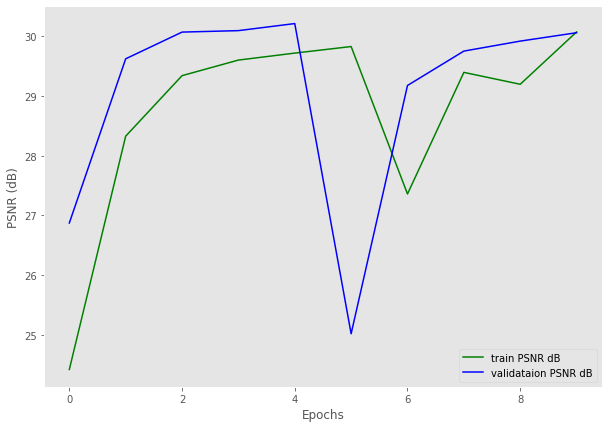

In [ ]:
#The loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# psnr plots
plt.figure(figsize=(10, 7))
plt.plot(train_psnr, color='green', label='train PSNR dB')
plt.plot(val_psnr, color='blue', label='validataion PSNR dB')
plt.xlabel('Epochs')
plt.ylabel('PSNR (dB)')
plt.legend()
plt.show()

# save the model to disk
#print('Saving model...')
#torch.save(model.state_dict(), '../outputs/model.pth')

In [ ]:
from google.colab import files

torch.save(model.state_dict(), 'checkpoint_9.pth')

## 6 Check model predictions

In [ ]:
model = SRCNN().to(device)
model.load_state_dict(torch.load('checkpoint_9.pth'))

<All keys matched successfully>

In [7]:
test_batch_size = 8
dataset = SkylineDataset(train_dir)
data_loader = DataLoader(dataset, batch_size=test_batch_size)

NameError: ignored

In [ ]:
X, Y = next(iter(data_loader))
Y_pred = model(X)

Text(0.5, 1.0, 'Predicted')

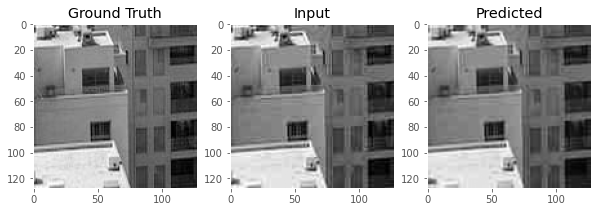

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
use_image = 7

truth = torchvision.utils.make_grid(Y[use_image], nrow=1)
truth = truth.permute(1, 2, 0).detach().numpy()
input = torchvision.utils.make_grid(X[use_image], nrow=1)
input = input.permute(1, 2, 0).detach().numpy()
pred = torchvision.utils.make_grid(Y_pred[use_image], nrow=1)
pred = pred.permute(1, 2, 0).detach().numpy()


axes[0].imshow(truth)
axes[0].set_title("Ground Truth")
axes[1].imshow(input)
axes[1].set_title("Input")
axes[2].imshow(pred)
axes[2].set_title("Predicted")